# Tarea 3 Ciencia de redes

> Thamara López, Fabián Ortega

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import community
import numpy as np


In [2]:
def get_community_matrix(A, com):
    n = len(A)
    
    # número de comunidades
    nc = len(set(com))

    # Inicializar lista de matrices de adyacencia
    e = np.zeros((nc, nc))

    # Crea enlace y normaliza valores dividiendo por la suma de todos los enlaces (dependiente del tamaño de la red)
    m = 0
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                ic = com[i]
                jc = com[j]
                if ic == jc:
                    e[ic,ic] += A[i, j]
                else:
                    e[ic,jc] += 0.5*A[i,j]
                    e[jc,ic] = e[ic,jc]
                m += A[i,j]
    return e/m

# Fast-Greedy

def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q

# Ejercicio 1 - Detección de comunidades en una red grande.
***Instricciones:***
1. Usa la funcioón `read_gml` para cargar la red en `group1.gml`.
2. Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.
3. ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?
4. Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a `node_size=20` para mayor claridad, ya que la red es grande. Use `pos=nx.kamada_kawai_layout(G)`
5. Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.
6. ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

In [3]:
# 1. cargamos archivo .gml
Gt = nx.read_gml("group1.gml")
# 2 usamos algoritmo Fast greedy para encontrar partición óptima
C, Q = fast_greedy(Gt)
# 3 Ordenamos C por tamaño de cada comunidad
C.sort(key=lambda t: len(t), reverse=True)
c1, c2 = C[:2] #Las dos comunidades mas grandes c1 y c2
others = set.union(*map(set, C[2:])) 
print("La modularidad de esta particion es:", Q)
print(f"El tamaño de la comunidad más grande es {len(c1)} ({round(len(c1)*100/len(Gt), 4) }%  de la red ) y el de la segunda comunidad es  {len(c2)}  ({round(len(c2)*100/len(Gt), 4) } % de la red)")
print(f"En otras comunidades quedan {len(others)} nodos.")

La modularidad de esta particion es: 0.42675796548512124
El tamaño de la comunidad más grande es 634 (0.5188%  de la red ) y el de la segunda comunidad es  544  (0.4452 % de la red)
En otras comunidades quedan 44 nodos.


In [5]:
pos=nx.kamada_kawai_layout(Gt)

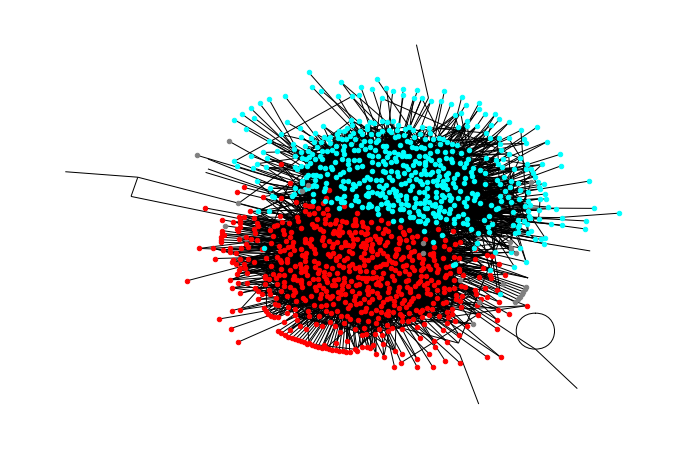

In [78]:
best_partition = [c1,c2,tuple(others)]

colors = ['red', 'cyan', 'gray']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos)

for community, color in zip(C, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

4. Al graficar las comunidades de la red, se puede observar de mejor manera el tamaño de las dos comunidades principales (denominadas c1 y c2), estas ocupan casi la totalidad de la red como se señaló en la pregunta anterior. Pero también se observa que son dos comunidades bien delimitadas entre sí, con muy pocos nodos que traspasan hacia el espacio de la otra comunidad.

5. La red pareciera estar compuesta por páginas web tipo blogs de política de Estados Unidos. En donde las 2 comunidades más grandes serian blogs asociados al pensamiento demócrata y los otros al repúblicano. (Liberales vs conservadores).

In [4]:
others

{'aldaron.modblog.com',
 'alphapredator.com/wdtgw.htm',
 'americanworldview.tripod.com/weltansblog',
 'batr.net',
 'batr.org/commentary.html',
 'blog.dennisfox.net',
 'blog.veggiedude.com',
 'bloghogger.blogspot.com',
 'charlesking.blogspot.com',
 'charleypatton.blogspot.com',
 'chiefsblog.blogspot.com',
 'churchofcriticalthinking.com',
 'conservativepolitics.blogspot.com',
 'cptnwinky.com',
 'democratvoice.org',
 'digitaljay.blogspot.com',
 'eltcamerica.blogspot.com',
 'enemykombatant.blogspot.com',
 'ergio.blogspot.com',
 'etalkinghead.com',
 'forewarned.blogspot.com',
 'ilovecynics.com',
 'imprescindibile.ilcannocchiale.it',
 'journals.aol.com/mark24609/myblog',
 'lennonreport.blogspot.com',
 'limericksavant.blogspot.com',
 'maggiespants.co.uk',
 'massachusetts-liberal.com',
 'myechochamber.blogspot.com',
 'nathancallahan.com',
 'neoconswatch.blogspot.com',
 'nicoladellarciprete.blogs.com',
 'nycitystoop.com',
 'openeyesmemo.com',
 'planetdave.com/blogs.php3?mid=1',
 'quimundus.modb

6. Son páginas en su mayoría no políticas y que probablemte tengan pocas referencias a otras páginas, que no hayan estado vinculadas directamente con motivos políticos.  